<a href="https://colab.research.google.com/github/nikita732/GAN/blob/main/Improved_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.10MB/s]


Начало обучения (с BatchNorm и Label Smoothing)...
Epoch [1/20] D Loss: 1.3339 G Loss: 0.8644


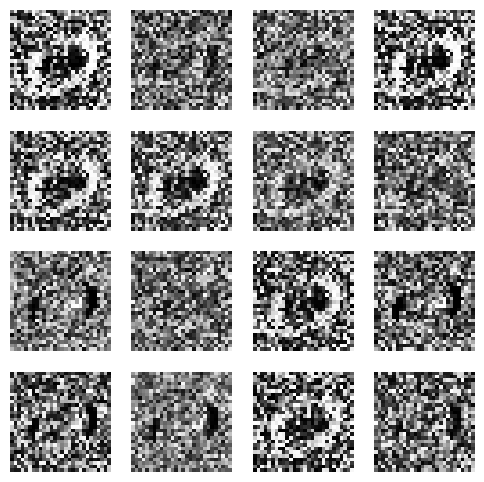

Epoch [2/20] D Loss: 0.7985 G Loss: 1.7874
Epoch [3/20] D Loss: 0.9837 G Loss: 1.8097
Epoch [4/20] D Loss: 1.2768 G Loss: 1.1618
Epoch [5/20] D Loss: 1.2446 G Loss: 1.1513


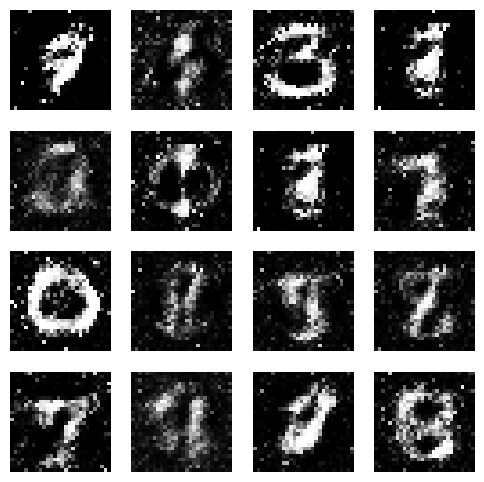

Epoch [6/20] D Loss: 1.2480 G Loss: 1.1513
Epoch [7/20] D Loss: 1.2372 G Loss: 1.1700
Epoch [8/20] D Loss: 1.2306 G Loss: 1.1845
Epoch [9/20] D Loss: 1.2179 G Loss: 1.2121
Epoch [10/20] D Loss: 1.2025 G Loss: 1.2483


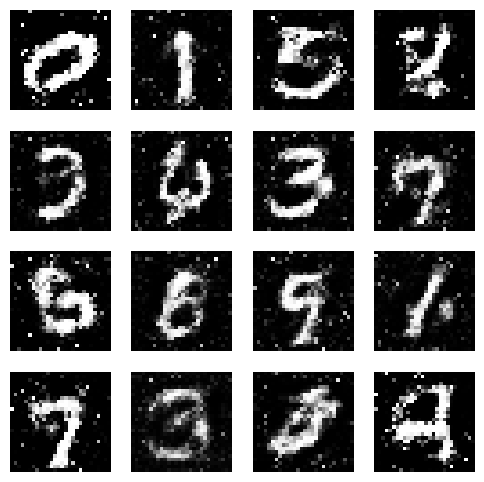

Epoch [11/20] D Loss: 1.2017 G Loss: 1.2492
Epoch [12/20] D Loss: 1.2003 G Loss: 1.2579
Epoch [13/20] D Loss: 1.2029 G Loss: 1.2780
Epoch [14/20] D Loss: 1.1830 G Loss: 1.2925
Epoch [15/20] D Loss: 1.1824 G Loss: 1.3184


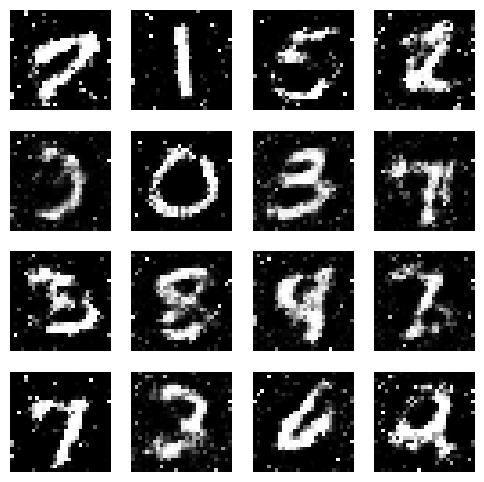

Epoch [16/20] D Loss: 1.1884 G Loss: 1.3107
Epoch [17/20] D Loss: 1.1869 G Loss: 1.3142
Epoch [18/20] D Loss: 1.1902 G Loss: 1.3080
Epoch [19/20] D Loss: 1.1904 G Loss: 1.2944
Epoch [20/20] D Loss: 1.2131 G Loss: 1.2866


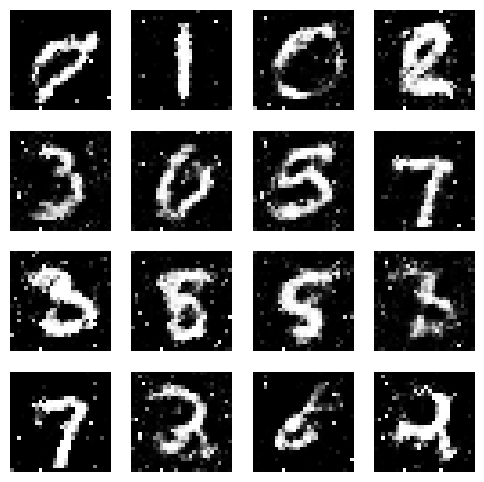

Обучение завершено!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Параметры
batch_size = 64
latent_dim = 100
image_size = 28 * 28
epochs = 20
lr = 0.0002

# Датасет MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Генератор с Batch Normalization
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256), # Добавлено
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512), # Добавлено
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024), # Добавлено
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

# Дискриминатор с BatchNorm
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512), # Добавлено
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), # Добавлено
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()
fixed_noise = torch.randn(16, latent_dim, device=device)

def show_generated_images(epoch):
    generator.eval() # Переводим в режим оценки
    with torch.no_grad():
        fake_images = generator(fixed_noise).cpu()
    generator.train()

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Тренировка
print("Начало обучения (с BatchNorm и Label Smoothing)...")
for epoch in range(epochs):
    d_losses, g_losses = [], []

    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Дискриминатор
        d_optimizer.zero_grad()

        real_labels = torch.full((current_batch_size, 1), 0.9, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, real_labels)

        z = torch.randn(current_batch_size, latent_dim, device=device)
        fake_images = generator(z)
        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Генератор
        g_optimizer.zero_grad()
        # Для генератора используем 1.0, чтобы он сильнее стремился к цели
        g_loss = criterion(discriminator(fake_images), torch.ones(current_batch_size, 1, device=device))
        g_loss.backward()
        g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] D Loss: {np.mean(d_losses):.4f} G Loss: {np.mean(g_losses):.4f}")
    if (epoch + 1) % 5 == 0 or epoch == 0:
        show_generated_images(epoch)

print("Обучение завершено!")